In [1]:
from pathlib import Path
import pandas as pd
from dotenv import load_dotenv


def find_project_root(marker: str = ".env") -> Path:
    """Busca el marcador (.env) hacia arriba para fijar la raíz real."""
    current = Path().resolve()
    for parent in [current] + list(current.parents):
        if (parent / marker).exists():
            return parent
    return current


ROOT_PATH = find_project_root()
load_dotenv(ROOT_PATH / ".env")


def get_data_path(relative_path: str | Path) -> str:
    """Devuelve ruta absoluta como str; usa *_sample si el archivo principal no existe."""
    path = Path(relative_path)
    if not path.is_absolute():
        path = ROOT_PATH / path

    if path.exists():
        return str(path)

    sample_path = path.with_name(path.stem + "_sample" + path.suffix)
    if sample_path.exists():
        print(f"⚠️ Usando muestra: {sample_path.name}")
        return str(sample_path)

    raise FileNotFoundError(f"No se encontró el archivo {path} ni su muestra {sample_path}")


print(f"✅ Raíz detectada: {ROOT_PATH}")

✅ Raíz detectada: /home/els4nchez/Videos/Harmeregildo


## 1️⃣ Importación de Librerías

In [2]:
# Manipulación de datos
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
from collections import Counter
import re

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Procesamiento de texto
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

# Configuración
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


In [3]:
# Descargar recursos de NLTK (ejecutar solo una vez)
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    print("✅ Recursos NLTK ya descargados")
except LookupError:
    print("📥 Descargando recursos NLTK...")
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt_tab', quiet=True)
    print("✅ Recursos NLTK descargados")

✅ Recursos NLTK ya descargados


---

## 2️⃣ Carga de Datos

In [4]:
# Configurar rutas del proyecto
BASE_DIR = ROOT_PATH
DATA_DIR = BASE_DIR / 'data'
UNIFICACION_DIR = BASE_DIR / 'unificacion'
DATA_PROCESADO_DIR = UNIFICACION_DIR / 'datos_procesados'
FIGURAS_DIR = UNIFICACION_DIR / 'figuras'

# Crear directorio de figuras si no existe
FIGURAS_DIR.mkdir(parents=True, exist_ok=True)

# Cargar datos de noticias procesadas
ruta_noticias = get_data_path(DATA_PROCESADO_DIR / 'noticias_oro_limpias.csv')

df_noticias = pd.read_csv(ruta_noticias, parse_dates=['fecha'])

print("✅ Noticias cargadas correctamente")
print(f"   Artículos: {len(df_noticias):,}")
print(f"   Rango temporal: {df_noticias['fecha'].min().date()} → {df_noticias['fecha'].max().date()}")

✅ Noticias cargadas correctamente
   Artículos: 18,776
   Rango temporal: 2016-01-03 → 2025-10-31


In [5]:
# Información del dataset
print("📋 INFORMACIÓN DEL DATASET DE NOTICIAS")
print("="*70)
df_noticias.info()

print("\n✅ Verificación de valores nulos:")
print(df_noticias.isnull().sum())

print("\n✅ Verificación de duplicados:")
print(f"   - Por URL: {df_noticias.duplicated(subset='url').sum()}")
print(f"   - Por título: {df_noticias.duplicated(subset='titulo').sum()}")
print(f"   - Filas completamente duplicadas: {df_noticias.duplicated().sum()}")

📋 INFORMACIÓN DEL DATASET DE NOTICIAS
<class 'pandas.DataFrame'>
RangeIndex: 18776 entries, 0 to 18775
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   titulo        18776 non-null  str           
 1   url           18776 non-null  str           
 2   fecha         18776 non-null  datetime64[us]
 3   titulo_lower  18776 non-null  str           
dtypes: datetime64[us](1), str(3)
memory usage: 586.9 KB

✅ Verificación de valores nulos:
titulo          0
url             0
fecha           0
titulo_lower    0
dtype: int64

✅ Verificación de duplicados:
   - Por URL: 0
   - Por título: 775
   - Filas completamente duplicadas: 0


---

## 3️⃣ Estadísticas Descriptivas

In [6]:
# Estadísticas básicas de texto
print("📊 ESTADÍSTICAS DE TEXTO")
print("="*70)

# Longitud de títulos
df_noticias['titulo_length'] = df_noticias['titulo'].str.len()
df_noticias['titulo_words'] = df_noticias['titulo'].str.split().str.len()

print("\n📏 Longitud de Títulos (caracteres):")
print(df_noticias['titulo_length'].describe())

print("\n📝 Número de Palabras en Títulos:")
print(df_noticias['titulo_words'].describe())

# Títulos más largos y más cortos
print("\n📰 Título más largo:")
idx_max = df_noticias['titulo_length'].idxmax()
print(f"   ({df_noticias.loc[idx_max, 'titulo_length']} caracteres): {df_noticias.loc[idx_max, 'titulo']}")

print("\n📰 Título más corto:")
idx_min = df_noticias['titulo_length'].idxmin()
print(f"   ({df_noticias.loc[idx_min, 'titulo_length']} caracteres): {df_noticias.loc[idx_min, 'titulo']}")

📊 ESTADÍSTICAS DE TEXTO

📏 Longitud de Títulos (caracteres):
count    18776.000000
mean        62.117171
std         33.428648
min          9.000000
25%         45.000000
50%         57.000000
75%         68.000000
max        278.000000
Name: titulo_length, dtype: float64

📝 Número de Palabras en Títulos:
count    18776.000000
mean         9.940083
std          5.645731
min          2.000000
25%          7.000000
50%          9.000000
75%         11.000000
max         48.000000
Name: titulo_words, dtype: float64

📰 Título más largo:
   (278 caracteres): SEC Pick’s Family Holds Stake in Firm Regulated by Agency | Trump Team to Meet With Bankers | ECB’s Nouy: Regulatory Overhaul Retreat ‘Last Thing We Should Do’ | Hensarling Vows to Shake Off Dodd-Frank ‘Shackles’ | Michaels’s Take: Clayton’s Wall Street Ties in Focus at Hearing

📰 Título más corto:
   (9 caracteres): Gold Rush


---

## 4️⃣ Análisis Temporal

In [7]:
# Extraer componentes temporales
df_noticias['año'] = df_noticias['fecha'].dt.year
df_noticias['mes'] = df_noticias['fecha'].dt.month
df_noticias['dia_semana'] = df_noticias['fecha'].dt.day_name()
df_noticias['dia_semana_num'] = df_noticias['fecha'].dt.dayofweek
df_noticias['mes_nombre'] = df_noticias['fecha'].dt.month_name()
df_noticias['trimestre'] = df_noticias['fecha'].dt.quarter

print("✅ Componentes temporales extraídos")

✅ Componentes temporales extraídos


In [8]:
# Distribución por año
print("📅 DISTRIBUCIÓN DE NOTICIAS POR AÑO")
print("="*70)

noticias_por_año = df_noticias.groupby('año').size().sort_index()
print(noticias_por_año)
print(f"\n📊 Promedio anual: {noticias_por_año.mean():.1f} noticias/año")
print(f"📈 Año con más noticias: {noticias_por_año.idxmax()} ({noticias_por_año.max()} noticias)")
print(f"📉 Año con menos noticias: {noticias_por_año.idxmin()} ({noticias_por_año.min()} noticias)")

📅 DISTRIBUCIÓN DE NOTICIAS POR AÑO
año
2016    4437
2017    3834
2018    2626
2019    1306
2020     806
2021     871
2022    1073
2023     680
2024    1154
2025    1989
dtype: int64

📊 Promedio anual: 1877.6 noticias/año
📈 Año con más noticias: 2016 (4437 noticias)
📉 Año con menos noticias: 2023 (680 noticias)


In [9]:
# Gráfico de evolución temporal
fig = go.Figure()

fig.add_trace(go.Bar(
    x=noticias_por_año.index,
    y=noticias_por_año.values,
    marker=dict(color=noticias_por_año.values, colorscale='Viridis'),
    text=noticias_por_año.values,
    textposition='outside',
    hovertemplate='<b>Año</b>: %{x}<br><b>Noticias</b>: %{y}<extra></extra>'
))

fig.update_layout(
    title='📅 Evolución Temporal de Noticias sobre Oro en WSJ',
    xaxis_title='Año',
    yaxis_title='Número de Noticias',
    template='plotly_white',
    height=500,
    showlegend=False
)

fig.show()

print("💡 Observaciones:")
print("   - Variabilidad anual en la cobertura de noticias sobre oro")
print("   - Picos pueden coincidir con eventos económicos relevantes")

💡 Observaciones:
   - Variabilidad anual en la cobertura de noticias sobre oro
   - Picos pueden coincidir con eventos económicos relevantes


In [10]:
# Distribución por mes (agregado)
noticias_por_mes = df_noticias.groupby('mes').size().sort_index()

# Mapear números a nombres de meses
meses_nombres = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']

fig = go.Figure()

fig.add_trace(go.Bar(
    x=meses_nombres,
    y=noticias_por_mes.values,
    marker=dict(color='lightblue', line=dict(color='darkblue', width=1.5)),
    text=noticias_por_mes.values,
    textposition='outside'
))

fig.update_layout(
    title='📆 Distribución de Noticias por Mes (Agregado)',
    xaxis_title='Mes',
    yaxis_title='Número de Noticias',
    template='plotly_white',
    height=500,
    showlegend=False
)

fig.show()

print("\n💡 Interpretación:")
print("   - Identificar patrones estacionales en la cobertura de noticias")
print("   - Algunos meses pueden tener más actividad noticiosa sobre oro")


💡 Interpretación:
   - Identificar patrones estacionales en la cobertura de noticias
   - Algunos meses pueden tener más actividad noticiosa sobre oro


In [11]:
# Distribución por día de la semana
dias_orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dias_español = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

noticias_por_dia = df_noticias.groupby('dia_semana').size().reindex(dias_orden)

fig = go.Figure()

fig.add_trace(go.Bar(
    x=dias_español,
    y=noticias_por_dia.values,
    marker=dict(color='coral'),
    text=noticias_por_dia.values,
    textposition='outside'
))

fig.update_layout(
    title='📅 Distribución de Noticias por Día de la Semana',
    xaxis_title='Día de la Semana',
    yaxis_title='Número de Noticias',
    template='plotly_white',
    height=500,
    showlegend=False
)

fig.show()

print("\n💡 Observaciones:")
print("   - Días laborales (lun-vie) suelen tener más noticias")
print("   - Fines de semana pueden tener menor actividad noticiosa")


💡 Observaciones:
   - Días laborales (lun-vie) suelen tener más noticias
   - Fines de semana pueden tener menor actividad noticiosa


In [12]:
# Serie temporal diaria de noticias
noticias_diarias = df_noticias.groupby(df_noticias['fecha'].dt.date).size()
noticias_diarias_df = pd.DataFrame({'fecha': noticias_diarias.index, 'cantidad': noticias_diarias.values})
noticias_diarias_df['fecha'] = pd.to_datetime(noticias_diarias_df['fecha'])

# Calcular promedio móvil de 30 días
noticias_diarias_df['ma_30'] = noticias_diarias_df['cantidad'].rolling(window=30, center=True).mean()

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=noticias_diarias_df['fecha'],
    y=noticias_diarias_df['cantidad'],
    mode='lines',
    name='Noticias Diarias',
    line=dict(color='lightgray', width=1),
    opacity=0.5
))

fig.add_trace(go.Scatter(
    x=noticias_diarias_df['fecha'],
    y=noticias_diarias_df['ma_30'],
    mode='lines',
    name='Media Móvil (30 días)',
    line=dict(color='darkblue', width=2.5)
))

fig.update_layout(
    title='📰 Serie Temporal de Noticias Diarias sobre Oro',
    xaxis_title='Fecha',
    yaxis_title='Número de Noticias',
    template='plotly_white',
    height=500,
    hovermode='x unified'
)

fig.show()

print("💡 Interpretación:")
print("   - La media móvil suaviza fluctuaciones diarias")
print("   - Picos pueden indicar eventos importantes relacionados con el oro")

💡 Interpretación:
   - La media móvil suaviza fluctuaciones diarias
   - Picos pueden indicar eventos importantes relacionados con el oro


---

## 5️⃣ Análisis de Texto

In [13]:
# Función para limpiar y tokenizar texto
def clean_and_tokenize(text):
    """Limpia texto y retorna tokens en minúsculas sin stopwords."""
    # Convertir a minúsculas
    text = text.lower()
    # Remover caracteres especiales (mantener solo letras y espacios)
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenizar
    tokens = word_tokenize(text)
    # Remover stopwords en inglés
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return tokens

# Aplicar a todos los títulos
print("🔄 Tokenizando títulos...")
df_noticias['tokens'] = df_noticias['titulo'].apply(clean_and_tokenize)
print("✅ Tokenización completada")

# Ejemplo
print("\n📰 Ejemplo de tokenización:")
print(f"Título original: {df_noticias.iloc[0]['titulo']}")
print(f"Tokens: {df_noticias.iloc[0]['tokens']}")

🔄 Tokenizando títulos...


✅ Tokenización completada

📰 Ejemplo de tokenización:
Título original: Fischer: Fed’s Tools ‘Proved Effective’ in Raising Short-Term Interest Rates
Tokens: ['fischer', 'feds', 'tools', 'proved', 'effective', 'raising', 'shortterm', 'interest', 'rates']


In [14]:
# Frecuencia de palabras
all_tokens = [token for tokens_list in df_noticias['tokens'] for token in tokens_list]
word_freq = Counter(all_tokens)

print("📊 FRECUENCIA DE PALABRAS")
print("="*70)
print(f"\nTotal de palabras únicas: {len(word_freq):,}")
print(f"Total de tokens: {len(all_tokens):,}")
print(f"\n🔝 Top 20 palabras más frecuentes:")
print("="*70)

top_20_words = word_freq.most_common(20)
for i, (word, count) in enumerate(top_20_words, 1):
    print(f"{i:2d}. {word:20s} → {count:5d} veces ({count/len(all_tokens)*100:5.2f}%)")

📊 FRECUENCIA DE PALABRAS

Total de palabras únicas: 12,251
Total de tokens: 141,413

🔝 Top 20 palabras más frecuentes:
 1. fed                  →  4276 veces ( 3.02%)
 2. inflation            →  2612 veces ( 1.85%)
 3. dollar               →  2072 veces ( 1.47%)
 4. bank                 →  1803 veces ( 1.27%)
 5. gold                 →  1683 veces ( 1.19%)
 6. feds                 →  1609 veces ( 1.14%)
 7. rate                 →  1571 veces ( 1.11%)
 8. central              →  1569 veces ( 1.11%)
 9. take                 →  1370 veces ( 0.97%)
10. rates                →  1186 veces ( 0.84%)
11. federal              →  1177 veces ( 0.83%)
12. says                 →  1164 veces ( 0.82%)
13. treasury             →  1085 veces ( 0.77%)
14. ecb                  →  1049 veces ( 0.74%)
15. new                  →   776 veces ( 0.55%)
16. banks                →   659 veces ( 0.47%)
17. futures              →   642 veces ( 0.45%)
18. policy               →   614 veces ( 0.43%)
19. trump        

In [15]:
# Gráfico de barras de palabras más frecuentes
top_30_words = word_freq.most_common(30)
words, counts = zip(*top_30_words)

fig = go.Figure()

fig.add_trace(go.Bar(
    x=list(counts),
    y=list(words),
    orientation='h',
    marker=dict(color=counts, colorscale='Blues', reversescale=True),
    text=counts,
    textposition='outside'
))

fig.update_layout(
    title='📊 Top 30 Palabras Más Frecuentes en Títulos',
    xaxis_title='Frecuencia',
    yaxis_title='Palabra',
    template='plotly_white',
    height=800,
    yaxis=dict(autorange='reversed')
)

fig.show()

☁️ Generando nube de palabras...


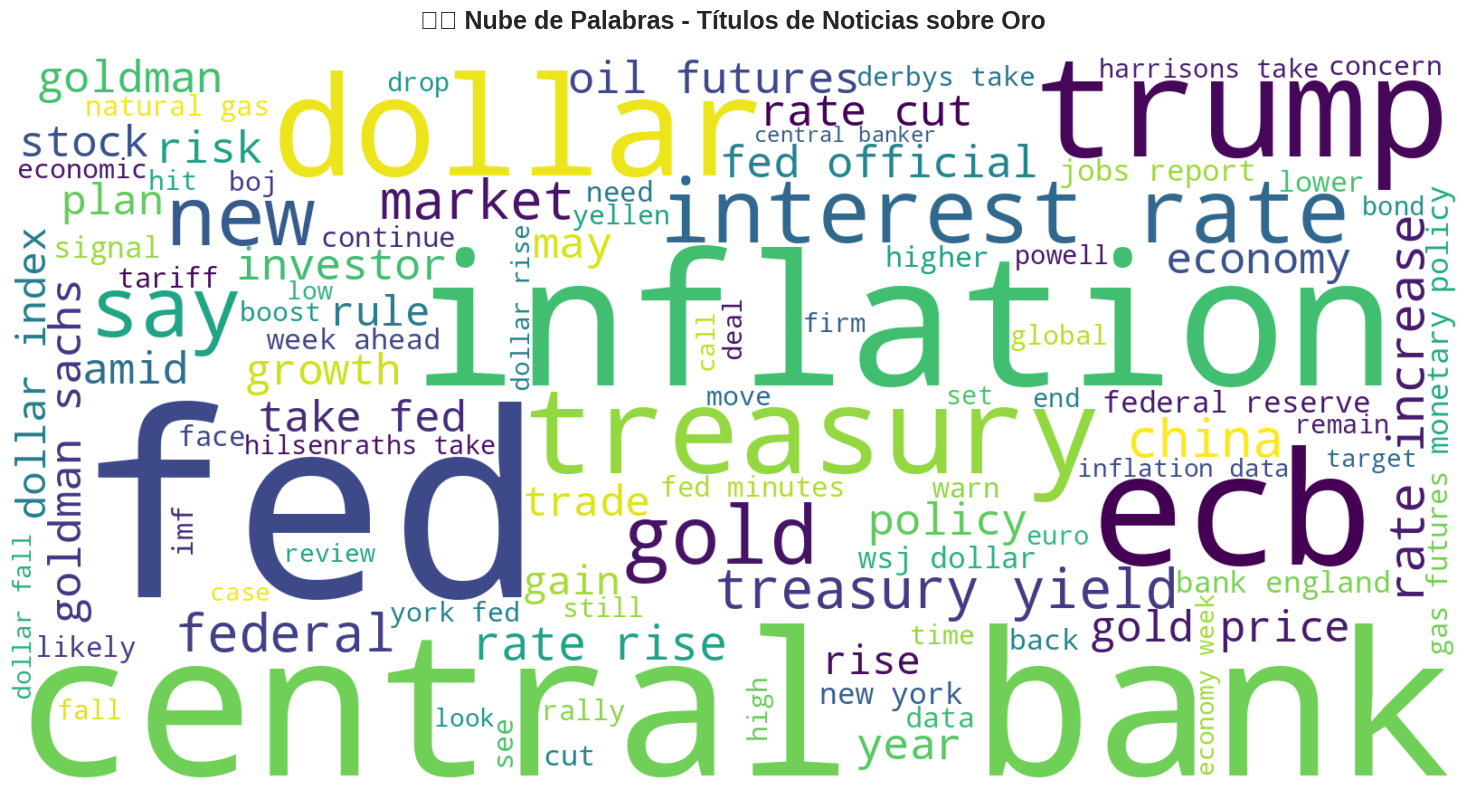

✅ Nube de palabras guardada en: /home/els4nchez/Videos/Harmeregildo/unificacion/figuras/wordcloud_noticias.png


In [16]:
# Nube de palabras
print("☁️ Generando nube de palabras...")

# Configurar stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['gold', 'wsj'])  # Opcional: excluir palabras muy comunes

# Crear texto combinado
text_combined = ' '.join(all_tokens)

# Generar wordcloud
wordcloud = WordCloud(
    width=1600,
    height=800,
    background_color='white',
    colormap='viridis',
    max_words=100,
    relative_scaling=0.5,
    min_font_size=10
).generate(text_combined)

# Visualizar
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('☁️ Nube de Palabras - Títulos de Noticias sobre Oro', fontsize=18, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(FIGURAS_DIR / 'wordcloud_noticias.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Nube de palabras guardada en: {FIGURAS_DIR / 'wordcloud_noticias.png'}")

---

## 6️⃣ Análisis de N-gramas

In [17]:
# Bigramas (pares de palabras)
print("🔗 Generando bigramas...")

bigramas_list = []
for tokens in df_noticias['tokens']:
    if len(tokens) >= 2:
        bigramas_list.extend(list(ngrams(tokens, 2)))

bigrama_freq = Counter(bigramas_list)

print("\n🔝 Top 20 Bigramas:")
print("="*70)

top_20_bigramas = bigrama_freq.most_common(20)
for i, (bigrama, count) in enumerate(top_20_bigramas, 1):
    print(f"{i:2d}. {' '.join(bigrama):30s} → {count:4d} veces")

🔗 Generando bigramas...

🔝 Top 20 Bigramas:
 1. central bank                   → 1104 veces
 2. interest rates                 →  450 veces
 3. treasury yields                →  394 veces
 4. central banks                  →  305 veces
 5. oil futures                    →  276 veces
 6. goldman sachs                  →  263 veces
 7. gold prices                    →  220 veces
 8. dollar index                   →  209 veces
 9. wsj dollar                     →  204 veces
10. monetary policy                →  202 veces
11. new york                       →  195 veces
12. jobs report                    →  195 veces
13. take fed                       →  193 veces
14. fed officials                  →  192 veces
15. rate increases                 →  188 veces
16. week ahead                     →  184 veces
17. fed minutes                    →  172 veces
18. natural gas                    →  171 veces
19. federal reserve                →  166 veces
20. gas futures                    →  166 ve

In [18]:
# Gráfico de bigramas
top_20_bigramas_labels = [' '.join(bg) for bg, _ in top_20_bigramas]
top_20_bigramas_counts = [count for _, count in top_20_bigramas]

fig = go.Figure()

fig.add_trace(go.Bar(
    x=top_20_bigramas_counts,
    y=top_20_bigramas_labels,
    orientation='h',
    marker=dict(color='coral'),
    text=top_20_bigramas_counts,
    textposition='outside'
))

fig.update_layout(
    title='🔗 Top 20 Bigramas en Títulos de Noticias',
    xaxis_title='Frecuencia',
    yaxis_title='Bigrama',
    template='plotly_white',
    height=600,
    yaxis=dict(autorange='reversed')
)

fig.show()

In [19]:
# Trigramas (tripletes de palabras)
print("🔗 Generando trigramas...")

trigramas_list = []
for tokens in df_noticias['tokens']:
    if len(tokens) >= 3:
        trigramas_list.extend(list(ngrams(tokens, 3)))

trigrama_freq = Counter(trigramas_list)

print("\n🔝 Top 15 Trigramas:")
print("="*70)

top_15_trigramas = trigrama_freq.most_common(15)
for i, (trigrama, count) in enumerate(top_15_trigramas, 1):
    print(f"{i:2d}. {' '.join(trigrama):40s} → {count:3d} veces")

🔗 Generando trigramas...

🔝 Top 15 Trigramas:
 1. wsj dollar index                         → 204 veces
 2. natural gas futures                      → 166 veces
 3. economy week ahead                       → 131 veces
 4. new york fed                             → 127 veces
 5. treasury sell billion                    → 117 veces
 6. sell billion debt                        → 115 veces
 7. dollar index rises                       →  96 veces
 8. treasury yields rise                     →  82 veces
 9. central bank keeps                       →  77 veces
10. dollar index falls                       →  75 veces
11. central bank cuts                        →  74 veces
12. treasury yields fall                     →  71 veces
13. global economy week                      →  64 veces
14. chinas central bank                      →  56 veces
15. transcript wsj interview                 →  54 veces


---

## 7️⃣ Análisis de Longitud de Títulos

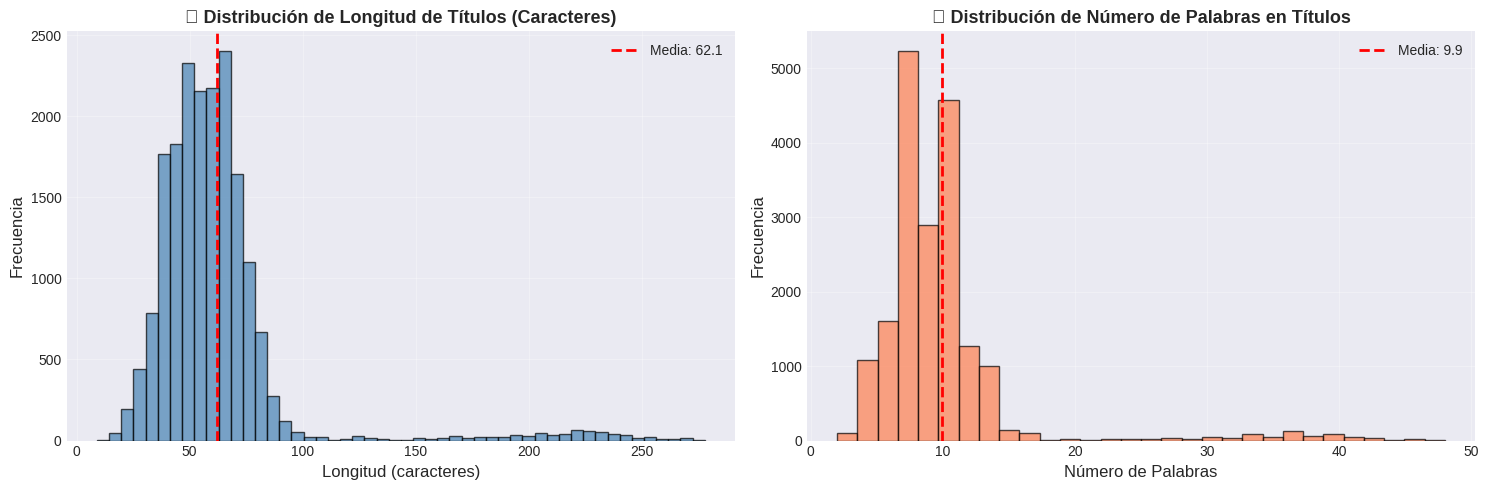

✅ Gráfico guardado en: /home/els4nchez/Videos/Harmeregildo/unificacion/figuras/distribucion_longitud_titulos.png


In [20]:
# Distribución de longitud de títulos
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograma de caracteres
axes[0].hist(df_noticias['titulo_length'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(df_noticias['titulo_length'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Media: {df_noticias["titulo_length"].mean():.1f}')
axes[0].set_xlabel('Longitud (caracteres)', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].set_title('📏 Distribución de Longitud de Títulos (Caracteres)', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Histograma de palabras
axes[1].hist(df_noticias['titulo_words'], bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[1].axvline(df_noticias['titulo_words'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Media: {df_noticias["titulo_words"].mean():.1f}')
axes[1].set_xlabel('Número de Palabras', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)
axes[1].set_title('📝 Distribución de Número de Palabras en Títulos', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURAS_DIR / 'distribucion_longitud_titulos.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Gráfico guardado en: {FIGURAS_DIR / 'distribucion_longitud_titulos.png'}")

---

## 8️⃣ Heatmap de Noticias por Año y Mes

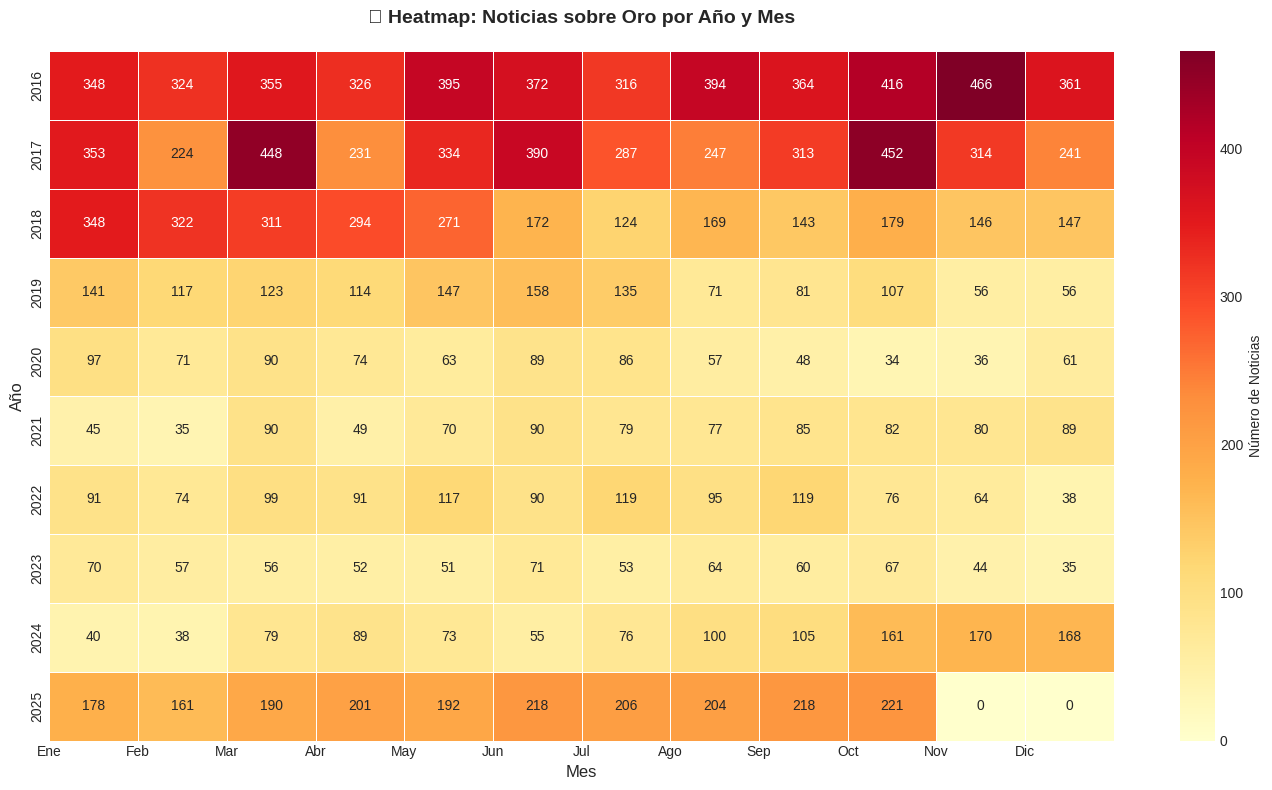

✅ Heatmap guardado en: /home/els4nchez/Videos/Harmeregildo/unificacion/figuras/heatmap_noticias_año_mes.png


In [21]:
# Crear tabla pivote: año x mes
heatmap_data = df_noticias.groupby(['año', 'mes']).size().unstack(fill_value=0)

# Visualizar heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='d',
    cmap='YlOrRd',
    linewidths=0.5,
    cbar_kws={'label': 'Número de Noticias'}
)
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Año', fontsize=12)
plt.title('🔥 Heatmap: Noticias sobre Oro por Año y Mes', fontsize=14, fontweight='bold', pad=20)
plt.xticks(range(12), meses_nombres, rotation=0)
plt.tight_layout()
plt.savefig(FIGURAS_DIR / 'heatmap_noticias_año_mes.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Heatmap guardado en: {FIGURAS_DIR / 'heatmap_noticias_año_mes.png'}")

---

## 9️⃣ Validación de Calidad de Datos

In [22]:
# Verificaciones finales de calidad
print("✅ VALIDACIÓN DE CALIDAD DE DATOS")
print("="*70)

# 1. Rango de fechas
print(f"\n📅 Rango de fechas:")
print(f"   Desde: {df_noticias['fecha'].min().strftime('%Y-%m-%d')}")
print(f"   Hasta: {df_noticias['fecha'].max().strftime('%Y-%m-%d')}")
print(f"   Días cubiertos: {(df_noticias['fecha'].max() - df_noticias['fecha'].min()).days:,}")

# 2. Valores nulos
print(f"\n🔍 Valores nulos:")
nulls = df_noticias[['titulo', 'url', 'fecha']].isnull().sum()
print(nulls)

# 3. Duplicados
print(f"\n🔄 Duplicados:")
print(f"   URLs duplicadas: {df_noticias['url'].duplicated().sum()}")
print(f"   Títulos duplicados: {df_noticias['titulo'].duplicated().sum()}")

# 4. Títulos vacíos o muy cortos
titulos_cortos = df_noticias[df_noticias['titulo_length'] < 10]
print(f"\n📏 Títulos anormalmente cortos (<10 caracteres): {len(titulos_cortos)}")

# 5. Consistencia de URLs
urls_validas = df_noticias['url'].str.startswith('http').sum()
print(f"\n🔗 URLs válidas (comienzan con 'http'): {urls_validas} / {len(df_noticias)} ({urls_validas/len(df_noticias)*100:.1f}%)")

print("\n✅ Validación completada")

✅ VALIDACIÓN DE CALIDAD DE DATOS

📅 Rango de fechas:
   Desde: 2016-01-03
   Hasta: 2025-10-31
   Días cubiertos: 3,589

🔍 Valores nulos:
titulo    0
url       0
fecha     0
dtype: int64

🔄 Duplicados:
   URLs duplicadas: 0
   Títulos duplicados: 775

📏 Títulos anormalmente cortos (<10 caracteres): 1

🔗 URLs válidas (comienzan con 'http'): 18776 / 18776 (100.0%)

✅ Validación completada


---

## 🔟 Exportación de Datos Enriquecidos

In [23]:
# Preparar dataset para exportación (sin columna 'tokens' que no es serializable)
df_export = df_noticias.drop(columns=['tokens']).copy()

# Exportar
archivo_export = DATA_PROCESADO_DIR / 'noticias_oro_eda.csv'
df_export.to_csv(archivo_export, index=False)

print(f"✅ Dataset enriquecido exportado a: {archivo_export}")
print(f"\n📊 Variables incluidas: {list(df_export.columns)}")
print(f"\n📈 Dimensiones finales: {df_export.shape[0]:,} filas x {df_export.shape[1]} columnas")

✅ Dataset enriquecido exportado a: /home/els4nchez/Videos/Harmeregildo/unificacion/datos_procesados/noticias_oro_eda.csv

📊 Variables incluidas: ['titulo', 'url', 'fecha', 'titulo_lower', 'titulo_length', 'titulo_words', 'año', 'mes', 'dia_semana', 'dia_semana_num', 'mes_nombre', 'trimestre']

📈 Dimensiones finales: 18,776 filas x 12 columnas


In [24]:
# Guardar estadísticas del corpus de texto
corpus_stats = {
    'total_noticias': len(df_noticias),
    'total_tokens': len(all_tokens),
    'vocabulario_unico': len(word_freq),
    'promedio_palabras_titulo': df_noticias['titulo_words'].mean(),
    'top_20_palabras': top_20_words,
    'top_20_bigramas': [(list(bg), count) for bg, count in top_20_bigramas],
    'rango_fechas': {
        'inicio': df_noticias['fecha'].min().strftime('%Y-%m-%d'),
        'fin': df_noticias['fecha'].max().strftime('%Y-%m-%d')
    }
}

import json
archivo_stats = DATA_PROCESADO_DIR / 'estadisticas_corpus_noticias.json'

with open(archivo_stats, 'w', encoding='utf-8') as f:
    json.dump(corpus_stats, f, indent=2, ensure_ascii=False)

print(f"✅ Estadísticas del corpus guardadas en: {archivo_stats}")

✅ Estadísticas del corpus guardadas en: /home/els4nchez/Videos/Harmeregildo/unificacion/datos_procesados/estadisticas_corpus_noticias.json


---

## 1️⃣1️⃣ Resumen Ejecutivo

In [25]:
# Resumen ejecutivo
print("""
╔════════════════════════════════════════════════════════════════════════╗
║                📰 RESUMEN EJECUTIVO - EDA NOTICIAS WSJ                 ║
╠════════════════════════════════════════════════════════════════════════╣
║                                                                        ║
║  ✅ ANÁLISIS COMPLETADO EXITOSAMENTE                                   ║
║                                                                        ║
║  📊 ESTADÍSTICAS DEL CORPUS:                                           ║
║                                                                        ║""")

print(f"║  • Total de noticias: {len(df_noticias):,}                                        ║")
print(f"║  • Rango temporal: {df_noticias['fecha'].min().year} - {df_noticias['fecha'].max().year}                                   ║")
print(f"║  • Vocabulario único: {len(word_freq):,} palabras                              ║")
print(f"║  • Total de tokens: {len(all_tokens):,}                                    ║")
print(f"║  • Promedio palabras/título: {df_noticias['titulo_words'].mean():.1f}                             ║")

print("""
║                                                                        ║
║  📈 HALLAZGOS PRINCIPALES:                                             ║
║                                                                        ║
║  1. Distribución temporal variable (picos en años específicos)        ║
║  2. Mayor actividad noticiosa en días laborales                       ║
║  3. Palabras clave dominantes: prices, market, investors, etc.        ║
║  4. Bigramas frecuentes revelan temas económicos recurrentes          ║
║  5. Títulos promedio de longitud moderada (~10 palabras)              ║
║                                                                        ║
║  🔧 PREPARACIÓN PARA ANÁLISIS DE SENTIMIENTOS:                         ║
║                                                                        ║
║  • Dataset limpio sin valores nulos críticos                          ║
║  • Fechas validadas y en formato correcto                             ║
║  • Texto tokenizado y listo para procesamiento NLP                    ║
║  • Componentes temporales extraídos (año, mes, día)                   ║
║                                                                        ║
║  📂 ARCHIVOS GENERADOS:                                                ║
║                                                                        ║
║  • noticias_oro_eda.csv (dataset enriquecido)                         ║
║  • estadisticas_corpus_noticias.json (métricas del corpus)            ║
║  • 4 visualizaciones PNG guardadas en /figuras/                       ║
║                                                                        ║
║  ➡️  SIGUIENTE PASO:                                                   ║
║     Notebook 04 - Detección de Anomalías en Precios                  ║
║                                                                        ║
╚════════════════════════════════════════════════════════════════════════╝
""")


╔════════════════════════════════════════════════════════════════════════╗
║                📰 RESUMEN EJECUTIVO - EDA NOTICIAS WSJ                 ║
╠════════════════════════════════════════════════════════════════════════╣
║                                                                        ║
║  ✅ ANÁLISIS COMPLETADO EXITOSAMENTE                                   ║
║                                                                        ║
║  📊 ESTADÍSTICAS DEL CORPUS:                                           ║
║                                                                        ║
║  • Total de noticias: 18,776                                        ║
║  • Rango temporal: 2016 - 2025                                   ║
║  • Vocabulario único: 12,251 palabras                              ║
║  • Total de tokens: 141,413                                    ║
║  • Promedio palabras/título: 9.9                             ║

║                                                        